<a href="https://colab.research.google.com/github/nikyan/Covid-19_Research/blob/master/Covid_19_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised classification of Covid research papers using LDA

- the goal of this analyis is to see how well we can use LDA to research covid papers
- are their ways to classify these articles into broad topics for analysis

## Import Libraries

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
import pickle
import json


from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import softcossim

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Extract Data

#### There are two types of PDFs.
- the PDFs of research papers are taken from Allen Institute (https://www.semanticscholar.org/cord19/download)
- for this analysis, I have only used the non-commercial subset

- data extraction was done in a separate notebook from json format and saved to sqlite db file.

##Load Data

In [0]:
# load data from database
def load_data():
    engine = create_engine('sqlite:///../content/drive/My Drive/ML data/ai2_research_data.db')
    df = pd.read_sql_table('research_data', engine)
    return df

    #/content/drive/My Drive/ML data/ai2_research_data.db

In [0]:
def save_data(df, database_filename):
    """
    A function to save df to a sqlite db
    
    INPUT:  
    df - dataframe with clean data that is saved to a sqlite db
    database_filename - name of database
    """
    engine = create_engine('sqlite:///{}'.format(database_filename))
    df.to_sql('research_papers', engine, index=False, if_exists='replace')

In [5]:
df = load_data()
print(df.shape)
df.head(2)

(4776, 3)


,paper_id,title,text
0,0036b28fddf7e93da0970303672934ea2f9944e7,The fecal microbiota and unconjugated fecal bi...,human type 1 DM. The aim of this study was to ...
1,004f0f69464edd5466a947da86d38cea9fe7e4fe,Human Pregnancy Specific Beta-1-Glycoprotein 1...,Pregnancy specific beta-1-glycoproteins (PSGs)...


In [0]:
# # get NDC drug data
# # https://www.fda.gov/drugs/drug-approvals-and-databases/national-drug-code-directory

# file1 = '../content/drive/My Drive/ML data/NDC Drug Data/package.txt'
# file2 = '../content/drive/My Drive/ML data/NDC Drug Data/product.txt'

# ndc_package = pd.read_table(file1)
# ndc_product = pd.read_table(file2, encoding = 'unicode_escape')

##Feature Exploration

In [7]:
# check if there's missing data
df.isnull().sum()


paper_id    0
title       0
text        0
dtype: int64

In [8]:
# Inspect text column
document_lengths = np.array(list(map(len, df.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 3764.922738693467.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 239553.


There is one document which has 1 word.

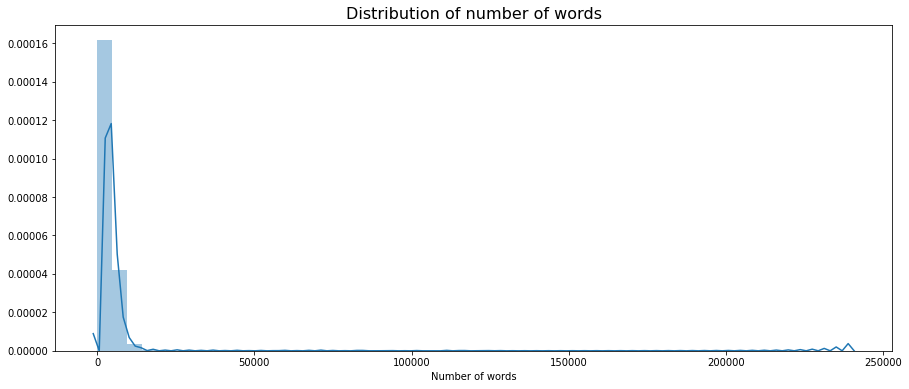

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

Lot of documents with words greater than 1500.

In [10]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))

shorter_documents = document_lengths[document_lengths <= 1500]

There are 3791 documents with over 1500 words.


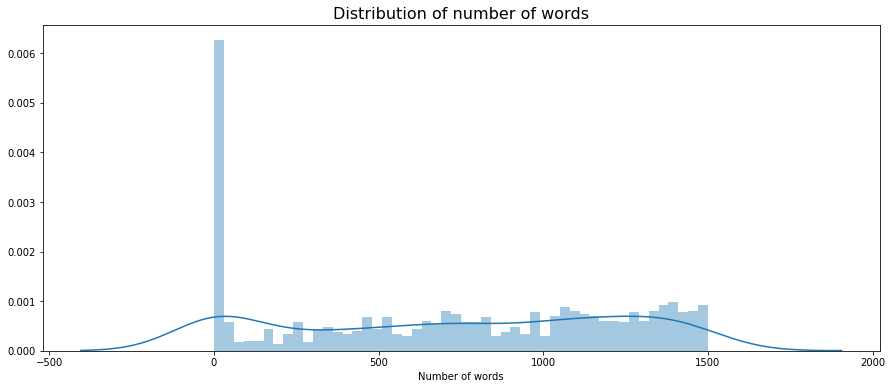

In [11]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [12]:
print("There are {} documents with max 5 words.".format(sum(document_lengths <= 5)))

There are 162 documents with max 5 words.


## Data Cleanup

In [0]:
# I did not use this in the current analysis.

# find and remove non-ascii words
# store non-ascii words to a special word in a variable for later use
# our_special_word = 'nonASCII'

# def remove_ascii_words(df):
#     """ removes non-ascii characters from the 'texts' column in df.
#     It returns the words containig non-ascii characers.
#     """
#     non_ascii_words = []
#     for i in range(len(df)):
#         for word in df.loc[i, 'text'].split(' '):
#             if any([ord(character) >= 128 for character in word]):
#                 non_ascii_words.append(word)
#                 df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, our_special_word)
#     return non_ascii_words

# non_ascii_words = remove_ascii_words(df)

# print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
#     len(non_ascii_words)))

In [0]:
# remove punctuation
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [0]:
# Here we get transform the documents into sentences
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(df)

In [0]:
# preprocessing steps for LDA

def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df)

In [0]:
#view top word frequencies

tokenized_only_dict = Counter(np.concatenate(df.tokenized_text.values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

tokenized_only_df.sort_values('count', ascending=False, inplace=True)

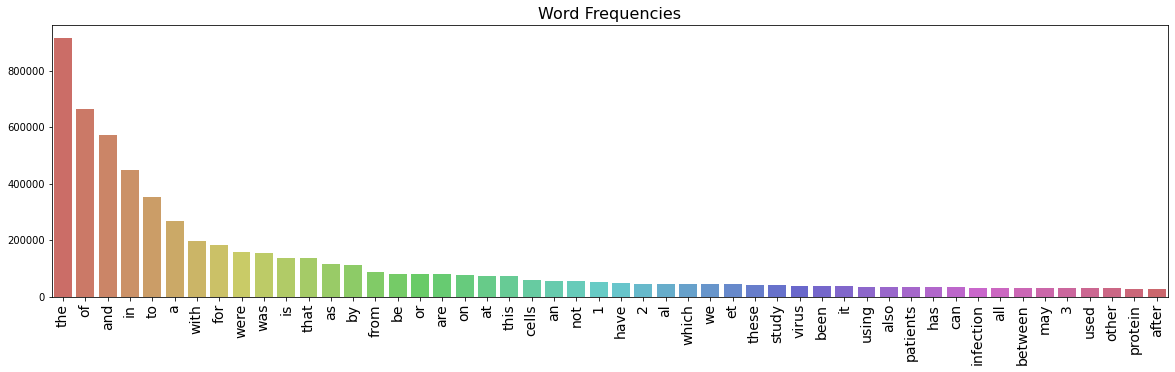

In [18]:
# function for word frequency 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
        returns a plot of word frequency.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

As expected, the highest frequency of words are the stopwords such as 'the', 'of', 'and' etc.

In [0]:
# remove stop words
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package.
    """
    # set of stopwords from nltk
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'nonASCII'
    #stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(df)

In [0]:
# lemmatization
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(df)

In [21]:
# dictionary for LDA
dictionary = Dictionary(documents=df.lemmatized_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 291494 words.


In [22]:
dictionary.filter_extremes(no_above=0.8, no_below=0)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 100000 words.


In [23]:
dictionary.doc2idx(['risk'])

[5126]

In [0]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.lemmatized_text))
    
document_to_bow(df)

In [0]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)
    

## Visualize cleansed data

In [0]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [0]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

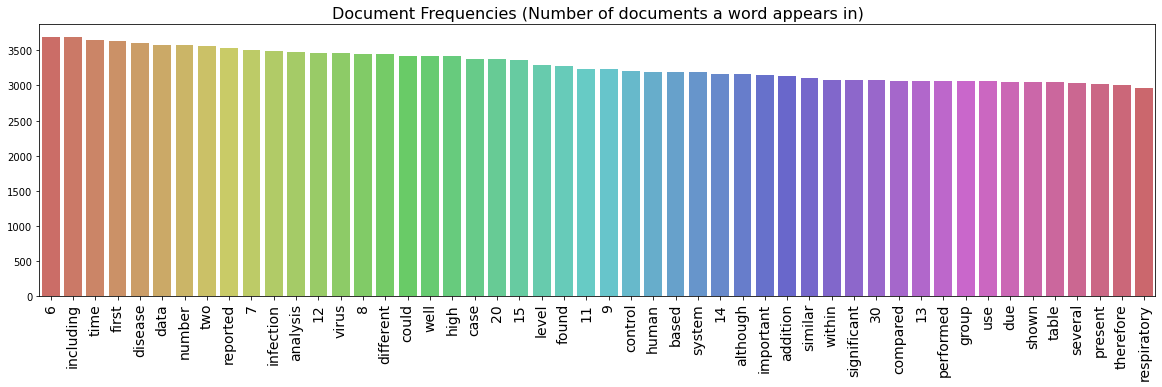

In [28]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

The above document frequecy doens't provide anything that we would not have guessed.

## LDA Training

In [0]:
# creat a list of possible covide related terms
# I will use this to filter out articles that have absolutely no mention of the covid-19 or related virus.
covidwords = ['covid', 'covid-19', 'corona', 'coronavirus', 'sars-cov-2', 'sarscov', 'mers', 'virus', 'h1n1', 'avian', 'influenza']

In [0]:
# identify papers with mention of corona virus or simiar virus such as sars, h1n1, mers
def identify_corona_papers(df):
    """ Identifies papers that have mention of corona virus based on a known set of words.
    """
  
    df['contains_corona'] = list(map(lambda doc:
                                       [word for word in doc if word in covidwords],
                                       df['tokenized_text']))
    df['contains_corona'] = list(map(lambda doc: None if len(doc) == 0 else doc, df['contains_corona']))

identify_corona_papers(df)

In [31]:
# how many articles that don't have any mention of corona virus
print(df.contains_corona.isnull().sum())

990


In [0]:
# filter out articles that have no mention of corona virus
df = df[~df.contains_corona.isnull()]

In [0]:
corpus = df.bow

In [34]:
# fit an LDA model
%%time
num_topics = 50
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 13min 53s, sys: 12min 3s, total: 25min 57s
Wall time: 10min 11s


In [0]:
# # save the model to disk
# filename = 'LDAmodel_v01.sav'
# pickle.dump(LDAmodel, open(filename, 'wb'))

In [0]:
# # load the model from disk
# LDAmodel = pickle.load(open(filename, 'rb'))

In [0]:
# returns topics with their probabilities
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    #print(topic_importances)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

df['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel, doc), df.bow))

In [0]:
# use this function to only get the first n topics by importance
def document_to_lda_topn_features(lda_model, document, n=10):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document, then sorts each topic for highest proportion and then returns n topics
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    
    # create a dictionary of all topics with their respective probabilities
    topic = {}
    for i in iter(topic_importances):
      topic.update({i[0] : i[1]})

    # sort each topic with highest probability
    top_n_topics = sorted(topic.items(), key=lambda x: x[1], reverse=True)
    
    # return top n topics for each document
    return top_n_topics[0:n]

df['lda_topn_features'] = list(map(lambda doc: document_to_lda_topn_features(LDAmodel, doc), df.bow))

In [0]:
# use this function to get the most dominant topic for a document
def document_to_lda_dominant_topic(lda_model, document, n=1):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document, then sorts each topic for highest proportion and then returns most dominant topic
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    
    # create a dictionary of all topics with their respective probabilities
    topic = {}
    for i in iter(topic_importances):
      topic.update({i[0] : i[1]})

    # sort each topic with highest probability
    top_n_topics = sorted(topic.items(), key=lambda x: x[1], reverse=True)
    
    # return top n topics for each document
    return top_n_topics[0:n][0][0]

df['lda_dominant_feature'] = list(map(lambda doc: document_to_lda_dominant_topic(LDAmodel, doc), df.bow))

In [0]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=20):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [41]:
#See the top words for given topics
for x in range(20):
  top_words = get_topic_top_words(LDAmodel, x)
  print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))

For topic 0, the top words are: merscov, case, infection, patient, disease, mers, virus, transmission, respiratory, outbreak, hospital, camel, contact, reported, human, health, among, saudi, symptom, confirmed.
For topic 1, the top words are: cell, virus, human, antibody, protein, disease, sarscov, gene, host, tumor, infection, cancer, epitope, patient, target, receptor, hcovemc, development, sars, immune.
For topic 2, the top words are: patient, virus, infection, influenza, respiratory, viral, sample, rsv, pcr, pathogen, test, clinical, detection, detected, bacterial, antibiotic, positive, specimen, kit, cav1.
For topic 3, the top words are: model, risk, data, individual, network, number, time, rate, contact, epidemic, disease, infection, influenza, group, transmission, country, population, outbreak, patient, information.
For topic 4, the top words are: patient, case, infection, day, disease, lung, respiratory, influenza, pneumonia, virus, clinical, severe, finding, showed, chest, ct,

In [0]:
#LDAmodel.show_topic(topicid=0, topn=20)
#LDAmodel.get_document_topics


In [0]:
# # not used
# # create a freature matrix
# feature_matrix = {}
# for idx, val in enumerate(df.lda_topn_features):
#   d1 = {}
#   for j in val:
#     d1.update({j[0]:j[1]})
#   feature_matrix.update({idx:d1})

# feature_matrix = pd.DataFrame(feature_matrix)
# feature_matrix = np.transpose(feature_matrix)
# feature_matrix.fillna(value=0, inplace=True)
# print(feature_matrix.shape)
# feature_matrix_paperid = feature_matrix.join(df.paper_id)

In [0]:
# # not used
# # convert feature_matrix to an array
# feature_topics = np.array(feature_matrix)

# # Take the dot product to obtain a topic x topic matrix of similarities
# dot_prod_feature_topics = feature_topics.dot(np.transpose(feature_topics))

In [0]:
# not used
# def find_similar_paper(paper_id):
#     '''
#     INPUT
#     paper_id - a paper_id 
#     OUTPUT
#     similar_paper - an array of the most similar paper by title
#     '''
#     # find the row of each paper id
#     paper_idx = np.where(feature_matrix_paperid['paper_id'] == paper_id)[0][0]
    
#     # find the most similar paper indices - to start I said they need to be the same for all content
#     similar_idxs = np.where(dot_prod_feature_topics[paper_idx] == np.max(dot_prod_feature_topics[paper_idx]))[0]
    
#     # pull the paper titles based on the indices
#     similar_paper = np.array(feature_matrix_paperid.iloc[similar_idxs, ]['paper_id'])
    
#     return similar_paper



In [0]:
# get title of paper for a given list of paper_ids
def get_paper_titles(paper_ids):
    '''
    INPUT
    paper_ids - a list of paper_ids
    OUTPUT
    paper - a list of paper names associated with the paper_ids
    
    '''
    paper_lst = list(df[df['paper_id'].isin(paper_ids)]['title'])
   
    return list(paper_lst)

## Data Exploration using LDA

In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

In [0]:
# most representative sentence for each topic

columns = ['paper_id', 'title', 'document_sentences', 'lda_dominant_feature']
df_sentence = df[columns]
df_sentence = df.groupby('lda_dominant_feature')

In [0]:
# get all topics with words and their probabilities
topics = LDAmodel.show_topics(formatted=False)

In [0]:
topics = LDAmodel.show_topics(formatted=False)
data_flat = [w for w_list in df.lemmatized_text for w in w_list]
counter = Counter(data_flat)

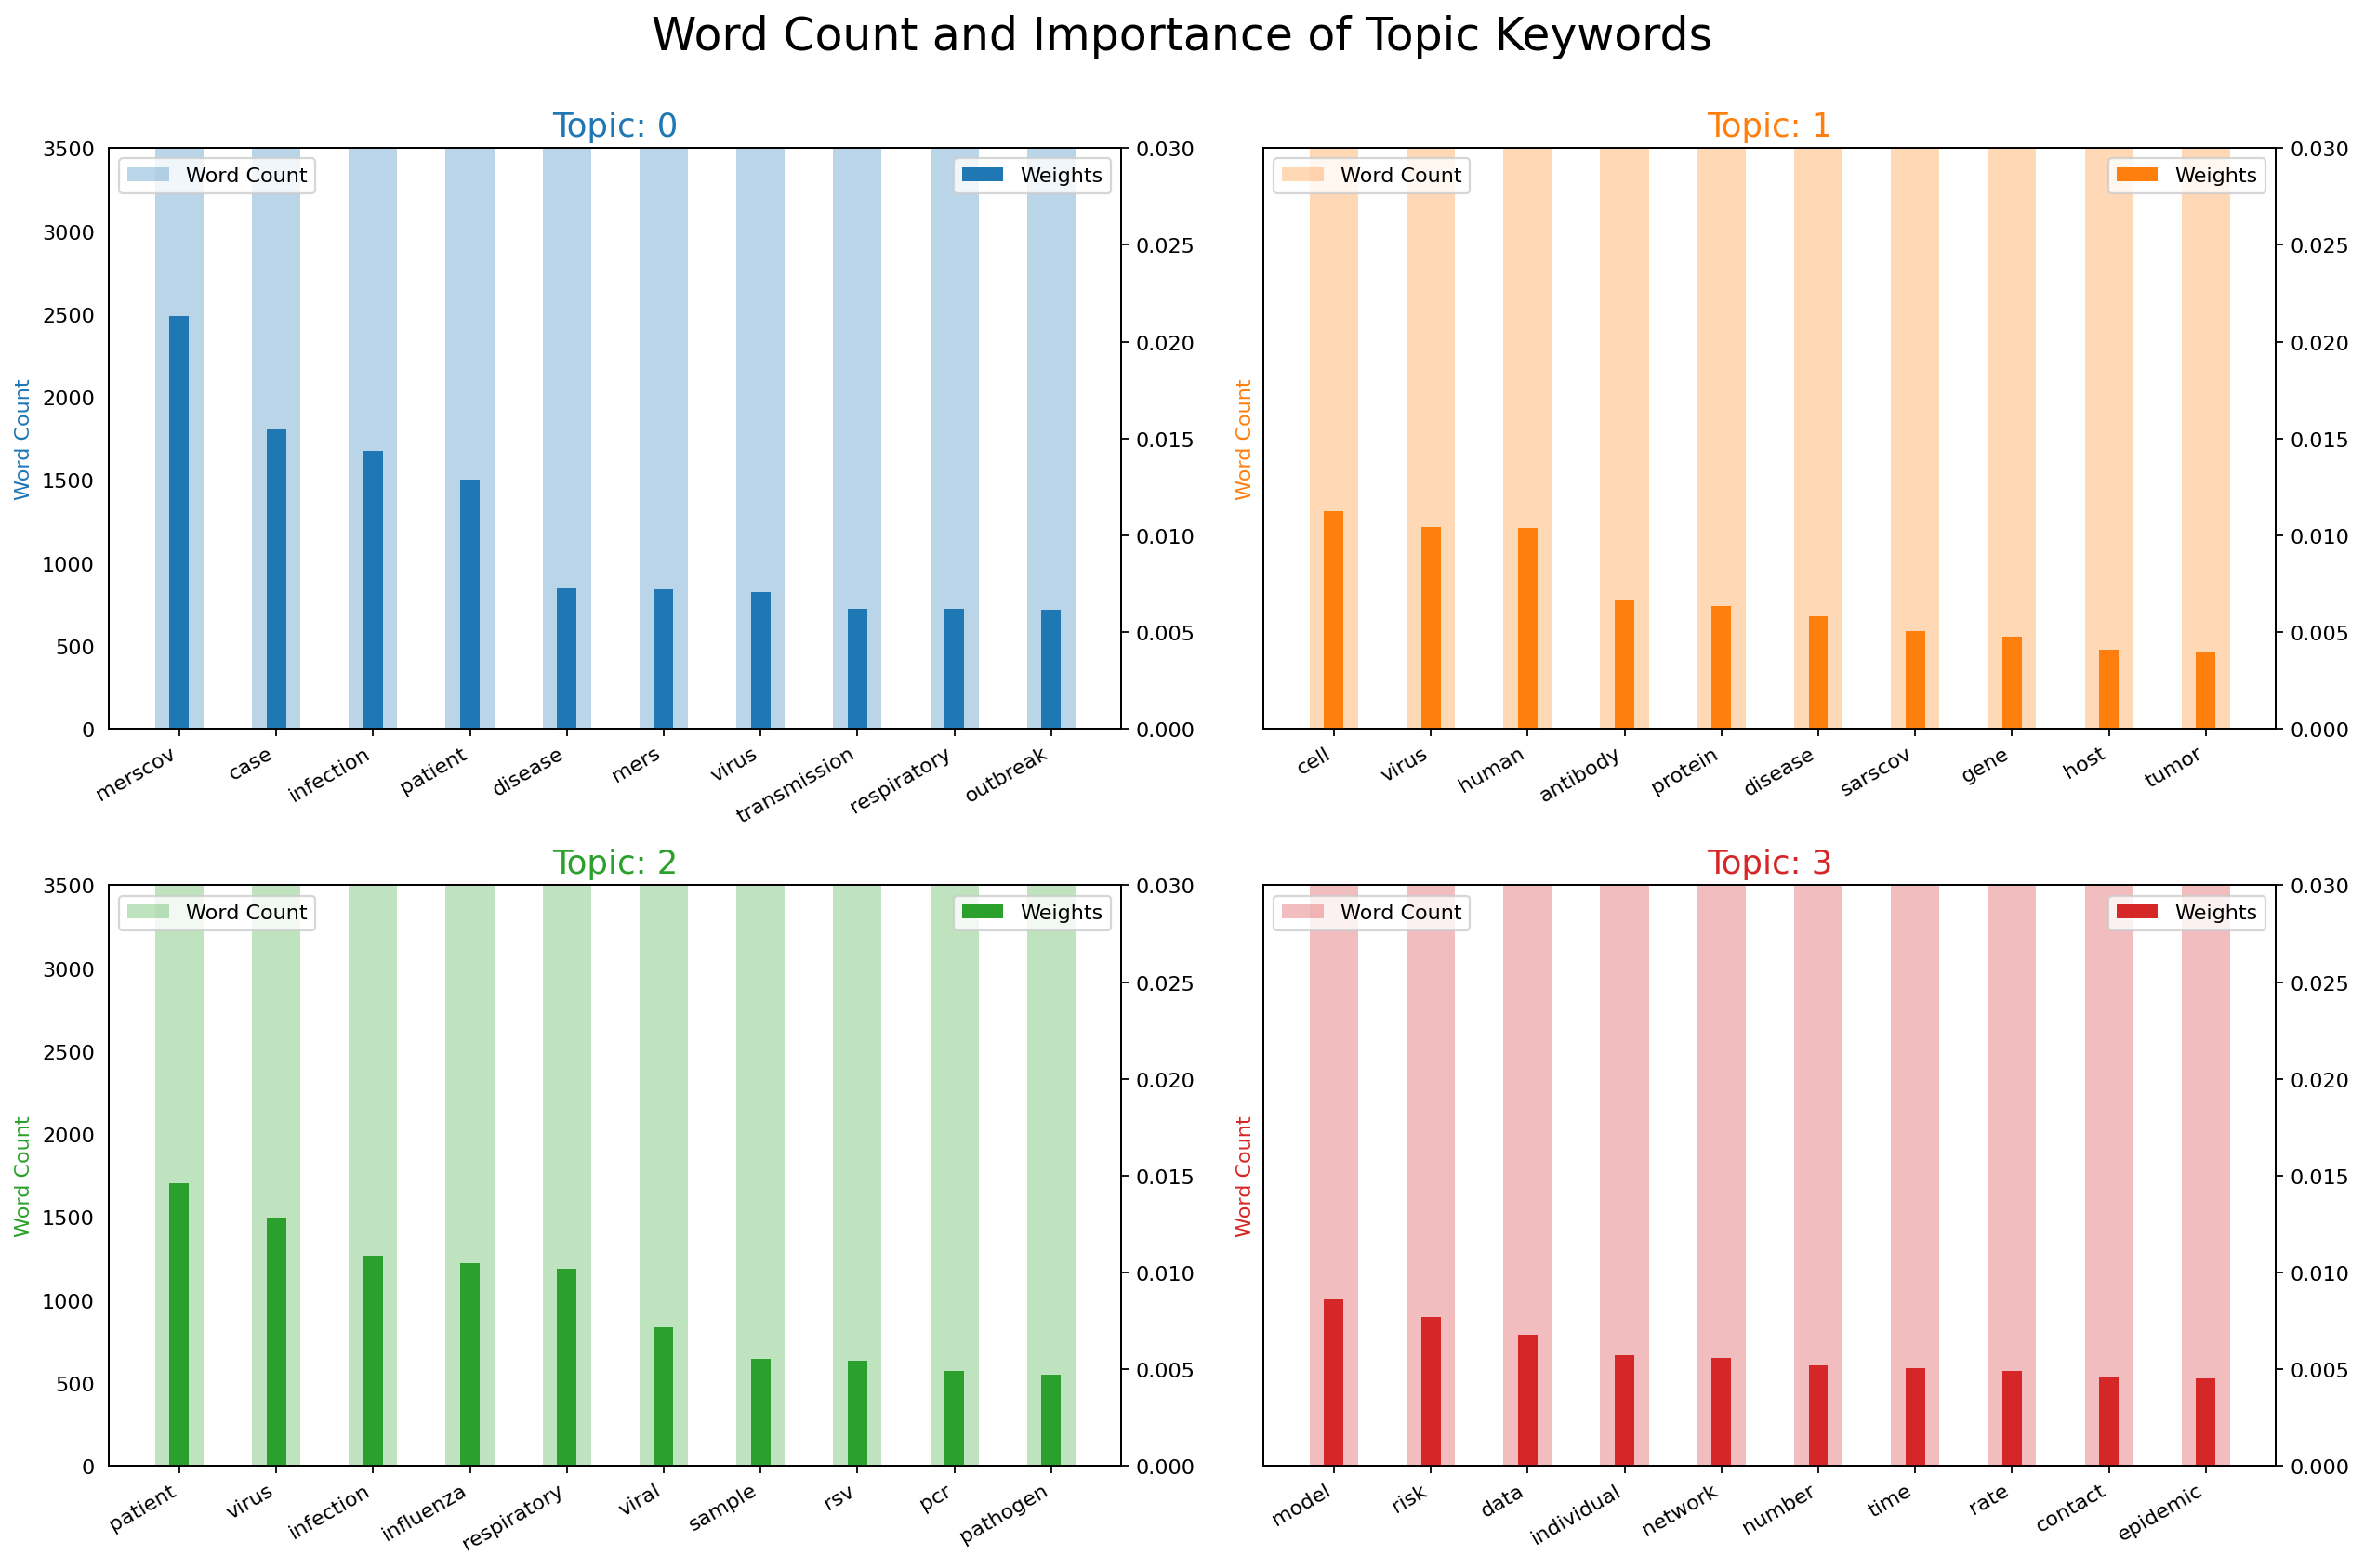

In [51]:
# lets look at the first 4 topics and their word counts
# code was used from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

topics = LDAmodel.show_topics(formatted=False)
data_flat = [w for w_list in df.lemmatized_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_wordcount = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_wordcount.loc[df_wordcount.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_wordcount.loc[df_wordcount.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_wordcount.loc[df_wordcount.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [0]:
# count the paper_ids for each dominant topic
df_groupby_dominant_topic = pd.DataFrame(df.groupby('lda_dominant_feature')['paper_id'].count())

(0.0, 400.0)

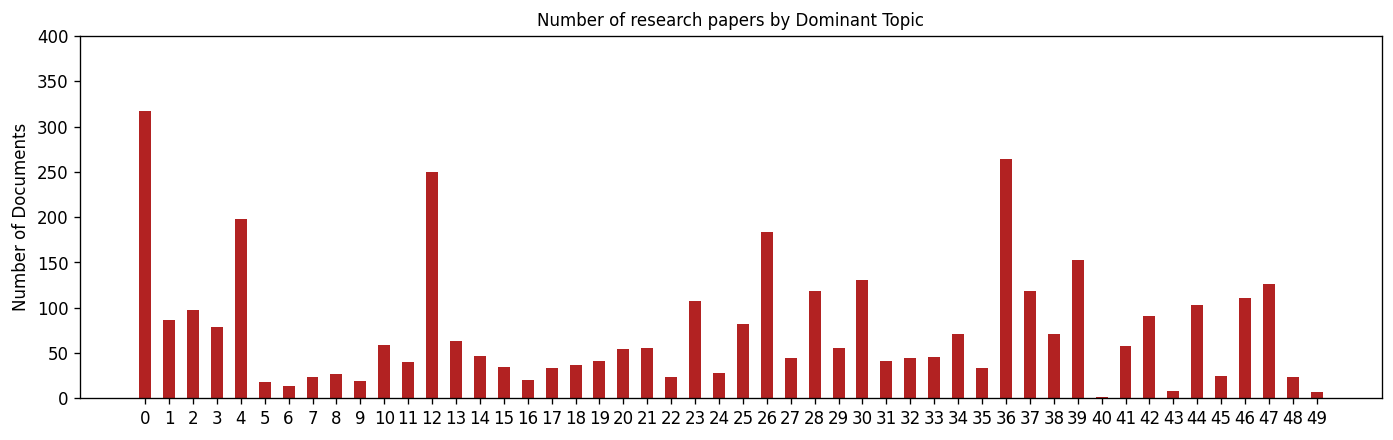

In [53]:
# Plot number of paper_ids that have each topic as dominant
fig, ax1 = plt.subplots(1, 1, figsize=(14, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x=df_groupby_dominant_topic.index, height='paper_id', data=df_groupby_dominant_topic, width=.5, color='firebrick')
ax1.set_xticks(range(df_groupby_dominant_topic.index.__len__()))
ax1.set_title('Number of research papers by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 400)

 - The first 4 topics have a range of 150 to 225 research papers.
 - Topics 30, 31 & 44 have the highest number of research papers.

Lets analyze the first two topics:

In [54]:
#most discussed topics in papers

# Topic 0 
topic0 = list(df.paper_id[df.lda_dominant_feature == 0])
get_paper_titles(topic0)

['Dromedary camels in northern Mali have high seropositivity to MERS-CoV-NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/)',
 'Communicable Diseases and Outbreak Control REVIEW 20',
 'An Appropriate Lower Respiratory Tract Specimen Is Essential for Diagnosis of Middle East Respiratory Syndrome (MERS)',
 '',
 'Article history: Cross-Country Comparison of Case Fatality Rates of COVID-19/SARS-COV-2',
 'COVID-19 in the Shadows of MERS-CoV in the Kingdom of Saudi Arabia',
 'The outbreak of COVID-19: An overview',
 'A fatal case caused by novel H7N9 avian influenza A virus in China',
 'The Middle East Respiratory Syndrome-How Worried Should We Be? A NOVEL VIRUS IS IDENTIFIED IN SAUDI ARABIA',
 'Cardiac problem and MERS',
 'A Case Report of a Middle East Respiratory Syndrome Survivor with Kidney Biopsy Results',
 'An Outbreak of Middle East Respiratory Syndrome Coronavirus Infection in South Korea, 2015',
 'Num 2',
 "Absence of MERS-CoV antibodies in feral camels in Australia:

In [55]:
# Topic 1
topic1 = list(df.paper_id[df.lda_dominant_feature == 1])
get_paper_titles(topic1)

['',
 'The Emergence of Human Coronavirus EMC: How Scared Should We Be?',
 '',
 'A sensitive array-based assay for identifying multiple TMPRSS2:ERG fusion gene variants',
 "Harnessing the immune system's arsenal: producing human monoclonal antibodies for therapeutics and investigating immune responses",
 'Forty years with coronaviruses',
 'Pharmacogenomics and Personalized Medicine Dovepress Glioblastoma extracellular vesicles: reservoirs of potential biomarkers',
 'B-cell restriction -an alternative piece to the puzzle',
 '',
 'Emerging Microbes and Infections (2012) 1, e35',
 'Emerging Microbes and Infections (2012) 1, e46',
 'Emerging Microbes and Infections (2012) 1, e23',
 'An Ecological Framework of the Human Virome Provides Classification of Current Knowledge and Identifies Areas of Forthcoming Discovery',
 'Human-livestock contacts and their relationship to transmission of zoonotic pathogens, a systematic review of literature-NC-ND license (http://creativecommons.org/licenses/b

In [56]:
# Topic 2
topic2 = list(df.paper_id[df.lda_dominant_feature == 2])
get_paper_titles(topic2)

['Open Forum Infectious Diseases Open Forum Infectious Diseases ® Outpatient Antibiotic Stewardship: A Growing Frontier-Combining Myxovirus Resistance Protein A With Other Biomarkers to Improve Antibiotic Use',
 'Rapid Multiplex Testing for Upper Respiratory Pathogens in the Emergency Department: A Randomized Controlled Trial',
 '',
 'Discrimination of Kawasaki disease with con comi tant adenoviral detection differentiating from isolated adenoviral infection',
 'PEER REVIEW HISTORY',
 'FULL PAPER Virology Development of a one-run real-time PCR detection system for pathogens associated with porcine respiratory diseases',
 'INQUIRY: The Journal of Health Care Organization, Provision, and Financing',
 'SEASONALITY OF VIRAL RESPIRATORY INFECTIONS IN SOUTHEAST OF BRAZIL: THE INFLUENCE OF TEMPERATURE AND AIR HUMIDITY Viral respiratory infections',
 'Fulminant ecchymosis as the initial manifestation of antiphospholipid syndrome (APS) triggered by respiratory syncytial virus (RSV) infection: A

In [58]:
# LDA visualization using pyLDAvis

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=LDAmodel, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)